# Projet 6: Classer des images à l'aide d'algorithmes de Deep Learning

Ce notebook est destiné à être exécuté sous google colab afin d'avoir facilement accès à un GPU.

# Les données

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf

Les données ont été stockées sur google drive afin d'y avoir facilement accès avec google colab.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


On spécifie deux constantes pour le projet: la taille des "batch" et les dimensions des images. En effet les images n'ont pas toutes les mêmes dimensions à l'origine, mais nos algorithme seront restreint à un seul format d'image en entrée.

In [3]:
batch_size = 32
imgsize = 224 # hauteur = largeur = 224

Les données sont très volumineuses donc on ne va pas charger toutes les données dans la mémoire RAM, mais les charger en temps voulu depuis le répertoir où elles sont stockées à l'aide de "image_dataset_from_directory()".

In [4]:
# Jeu de données d'entraînement
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Dogs_images',
    validation_split=0.2,
    subset='training',
    seed=21,
    image_size=(imgsize, imgsize),
    batch_size=batch_size)

Found 1125 files belonging to 6 classes.
Using 900 files for training.


In [5]:
# Jeu de données de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Dogs_images',
    validation_split=0.2,
    subset='validation',
    seed=21,
    image_size=(imgsize, imgsize),
    batch_size=batch_size)

Found 1125 files belonging to 6 classes.
Using 225 files for validation.


In [6]:
class_names = train_ds.class_names
class_names

['Afghan_hound',
 'Basset',
 'Chihuahua',
 'Doberman',
 'English_foxhound',
 'Maltese']

Remarque: pour espérer avoir des résultats pas trop mauvais avec les modèles sans transfert learning il ne faut pas prendre trop de classes différentes et faire en sorte que les races de chien (les classes) ne se ressemblent pas trop. 

In [7]:
nbr_classes = len(class_names)
nbr_classes

6

Jetons un coup d'oeil sur nos données.

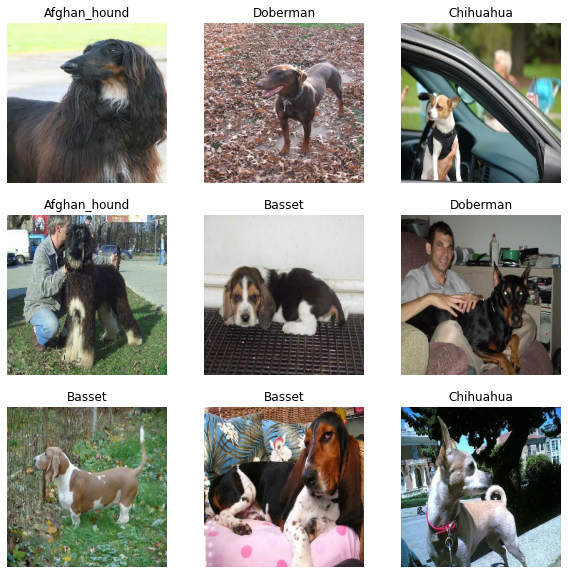

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Avant de nous lancer dans le machine learning nous allons voir quelques méthodes de traitement d'images. Cela nous sera utile pour éviter le sur-apprentissage de nos modèles.

# Traitement des images

On se fixe une image et nous allons la modifier de plein de façons différentes.

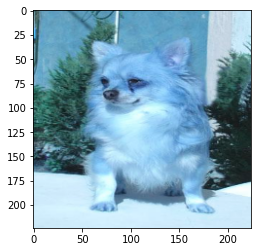

In [9]:
img = cv2.imread('/content/gdrive/MyDrive/Dogs_images/Chihuahua/n02085620_199.jpg',cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))
plt.imshow(img)

## Transformations élémentaires avec numpy

Dans cette section nous allons faire des modifications très simples à coder: trois translations et un ajout de bruit. 

Remarque: les trois translations ne font que montrer les modifications sans renvoyer l'image modifiée, alors que l'ajout de bruit renvoie l'image modifiée parce qu'on l'utilisera un peu plus tard.

In [10]:
shift = 40 # nombre de pixels dont on veut décaler l'image
figsize = (8,8)

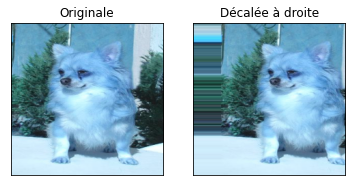

In [11]:
def translation_droite(img, shift, figsize=figsize):
    W = img.shape[0]
    H = img.shape[1]
    new_img = img.copy()

    for i in range(W-1, shift, -1):
        for j in range(H):
            new_img[j][i] = new_img[j][i-shift]
    for i in range(shift, 0, -1):# pour éviter de dédoubler une bande complète de l'image
        for j in range(H):
            new_img[j][i] = new_img[j][0]

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Décalée à droite')
    plt.xticks([]), plt.yticks([])

translation_droite(img, shift, figsize=figsize)

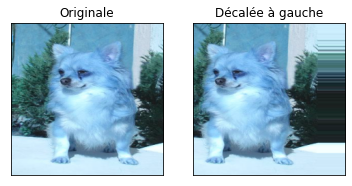

In [12]:
def translation_gauche(img, shift, figsize=figsize):
    W = img.shape[0]
    H = img.shape[1]
    new_img = img.copy()

    for j in range(H):
        for i in range(W):
            if (i < W-shift):
                new_img[j][i] = new_img[j][i+shift]
            else:
                new_img[j][i] = new_img[j][W-1]

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Décalée à gauche')
    plt.xticks([]), plt.yticks([])
    
translation_gauche(img, shift, figsize=figsize)

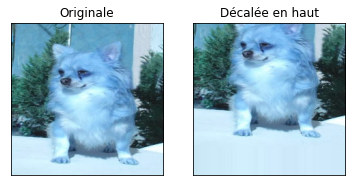

In [13]:
def translation_haut(img, shift, figsize=figsize):
    W = img.shape[0]
    H = img.shape[1]
    new_img = img.copy()

    for j in range(H):
        for i in range(W):
            if (j < H-shift):
                new_img[j][i] = new_img[j + shift][i]
            else:
                new_img[j][i] = new_img[H-1][i]

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Décalée en haut')
    plt.xticks([]), plt.yticks([])
    
translation_haut(img, shift, figsize=figsize)

On peut, d'une façon similaire, écrire une fonction "translation_bas".

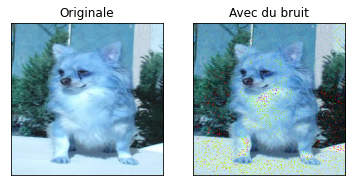

In [14]:
def bruit_gaussien(img, sigma, figsize=figsize):
    # Modifie les valeur RGB des pixels de l'image img, selon une loi normal centrée de variance sigma
    W = img.shape[0]
    H = img.shape[1]
    new_img = img.copy()

    noise = np.random.normal(- sigma,  sigma, size=(imgsize, imgsize, 3))

    for j in range(W):
        for i in range(H):
            for k in range(3):
                new_img[i][j][k] += noise[i][j][k]
                new_img[i][j][k] = new_img[i][j][k] % 255

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Avec du bruit')
    plt.xticks([]), plt.yticks([])
    return new_img
    
img_avec_bruit = bruit_gaussien(img, 10, figsize=figsize)

## Avec ImageDataGenerator

La classe ImageDataGenerator nous permet d'effectuer des modifications de manière aléatoire parmis une gamme de modifications choisies. Nous allons en tester quelques-une.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

On créé une classe pour montrer les exemples.

In [16]:
class ShowImageGenerator(ImageDataGenerator):
    
    def show(self, image, figsize=(10, 5), n_range=6, fit_data=None):
        
        if fit_data is not None:
            self.fit(fit_data)
        samples = np.expand_dims(image, 0)
        it = self.flow(samples, batch_size=1)
        plt.figure(figsize=figsize)
        for i in range(n_range):
            plt.subplot(2, 3, i+1)
            for x in it:
                plt.imshow(x[0].astype('uint8'))
                plt.xticks([]), plt.yticks([])
                break
        plt.show()

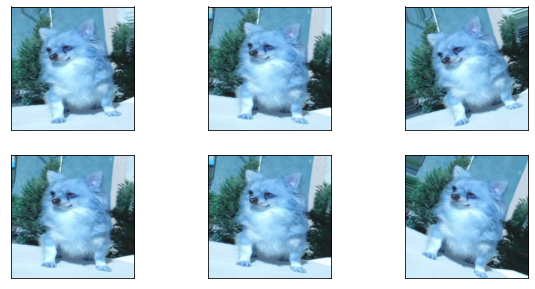

In [17]:
# Rotations de l'image
datagen = ShowImageGenerator(rotation_range=30)
datagen.show(image=img)

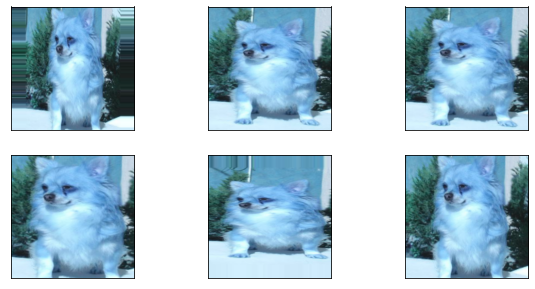

In [18]:
# Zooms
datagen = ShowImageGenerator(zoom_range = 0.3)
datagen.show(image=img)

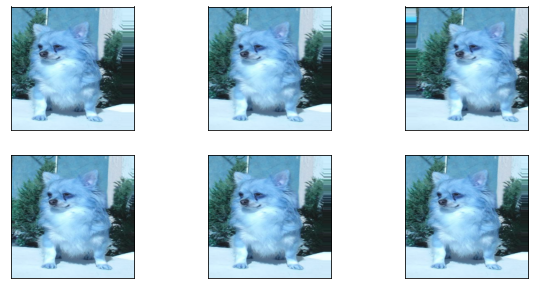

In [19]:
# Translations horizontales
datagen = ShowImageGenerator(width_shift_range=0.2)
datagen.show(image=img)

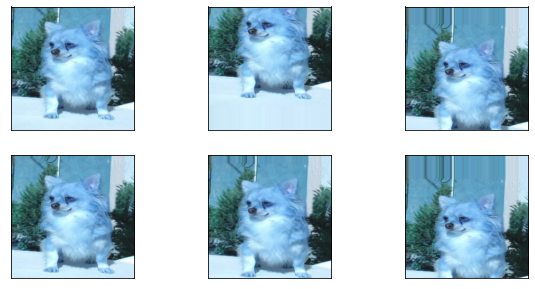

In [20]:
# Translations verticales
datagen = ShowImageGenerator(height_shift_range=0.2)
datagen.show(image=img)

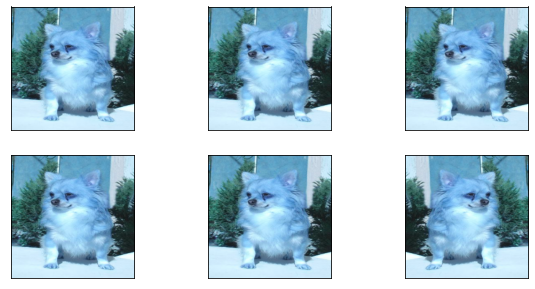

In [21]:
# Symétrie axiale
datagen = ShowImageGenerator(horizontal_flip=True)
datagen.show(image=img)

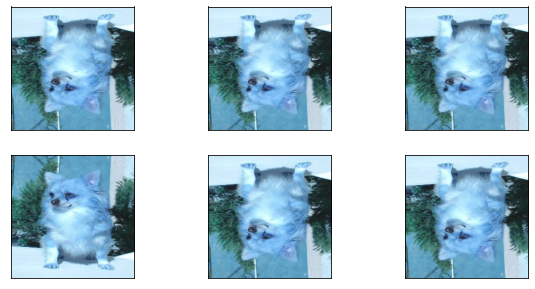

In [22]:
# Symétrie axiale
datagen = ShowImageGenerator(vertical_flip=True)
datagen.show(image=img)

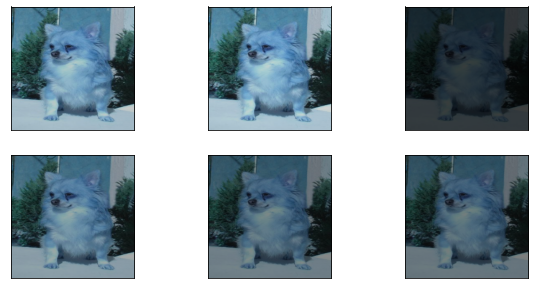

In [23]:
# Luminosité
datagen = ShowImageGenerator(brightness_range=[0.2,1.0])

datagen.show(image=img)

## Utilisation de filtres avec cv2

Cette fois-ci on va modifier la couleur d'un pixel en fonction de la couleur des pixels autours de lui.

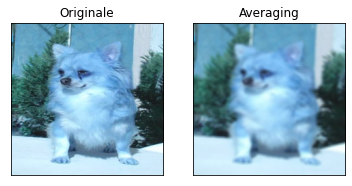

In [24]:
def filtre_moyenne(img, kernel, figsize=figsize):
    
    new_img = cv2.filter2D(img,-1,kernel)

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Averaging')
    plt.xticks([]), plt.yticks([])

kernel = np.ones((5,5),np.float32)/25
filtre_moyenne(img, kernel, figsize=figsize)

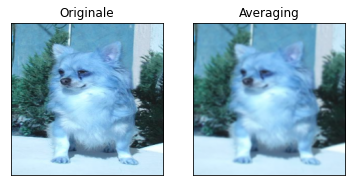

In [25]:
def filtre_gaussien(img, ksize, sigmaX, sigmaY, figsize=figsize):
    
    new_img = cv2.GaussianBlur(img, ksize, sigmaX, sigmaY)

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Averaging')
    plt.xticks([]), plt.yticks([])

filtre_gaussien(img, ksize=(5,5), sigmaX=0, sigmaY=0, figsize=figsize)

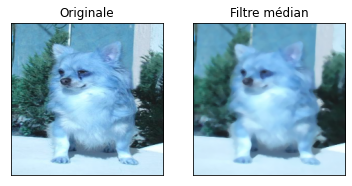

In [26]:
def filtre_median(img, ksize, figsize=figsize):
    
    new_img = cv2.medianBlur(img, ksize)

    plt.subplot(121),plt.imshow(img),plt.title('Originale')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(new_img),plt.title('Filtre médian')
    plt.xticks([]), plt.yticks([])

filtre_median(img, ksize=5, figsize=figsize)

On va tester deux de ces filtres sur notre image avec bruit.

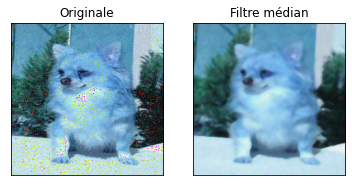

In [27]:
filtre_median(img_avec_bruit, ksize=5, figsize=figsize)

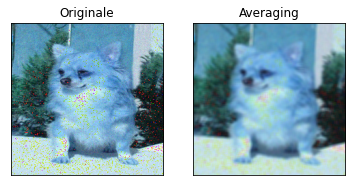

In [28]:
filtre_moyenne(img_avec_bruit, kernel, figsize=figsize)

On remarque que le filtre médian est efficace pour supprimer le bruit, alors que le filtre moyen de l'est pas. Ce qui est logique puisque, contrairement à la médiane, la moyenne est très sensible aux valeurs extrêmes.

Passons maintenant à la modélisation.

# Modélisation

Nous allons voir deux approches. Tous d'abord nous allons construire des modèles que nous allons entièrement entraîner. Puis nous fabriquerons des modèles à partir de modèles déjà entraînés (transfert learning).

## Création d'un réseau CNN

### Création d'un premier modèle

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Rescaling

In [30]:
tf.random.set_seed(21)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
# Création du modèle
model = Sequential([
  Rescaling(1./255,  input_shape=(imgsize, imgsize, 3)),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(nbr_classes, activation='softmax') 
])

# Compilation du modèle
model.compile(loss="SparseCategoricalCrossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Entraînement
history = model.fit(train_ds,  
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=test_ds)

Epoch 1/50
29/29 [==============================] - 126s 1s/step - loss: 1.7776 - accuracy: 0.2467 - val_loss: 1.7456 - val_accuracy: 0.3022
Epoch 2/50
29/29 [==============================] - 1s 44ms/step - loss: 1.6679 - accuracy: 0.3278 - val_loss: 1.6679 - val_accuracy: 0.3067
Epoch 3/50
29/29 [==============================] - 1s 42ms/step - loss: 1.4508 - accuracy: 0.4411 - val_loss: 1.5014 - val_accuracy: 0.3867
Epoch 4/50
29/29 [==============================] - 1s 41ms/step - loss: 1.3038 - accuracy: 0.5111 - val_loss: 1.5085 - val_accuracy: 0.3867
Epoch 5/50
29/29 [==============================] - 1s 40ms/step - loss: 1.1720 - accuracy: 0.5733 - val_loss: 1.5742 - val_accuracy: 0.4133
Epoch 6/50
29/29 [==============================] - 1s 41ms/step - loss: 0.9906 - accuracy: 0.6556 - val_loss: 1.7346 - val_accuracy: 0.3911
Epoch 7/50
29/29 [==============================] - 1s 41ms/step - loss: 0.7833 - accuracy: 0.7378 - val_loss: 1.8729 - val_accuracy: 0.3778
Epoch 8/50
29

En général 50 epochs est trop peu pour obtenir un bon résultat mais dans ce projet on a des modèles qui atteigne très vite un seuil d'apprentissage.

In [33]:
# Pour voir la structure du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                        

## Tracer des courbes 'loss' et 'accuracy'

Dans cette section nous allons simplement écrire une fonction pour visualiser ce qui se passe lors de l'entraînement d'un modèle.

In [34]:
def plot_loss_curves(history):
    """
    Trace les courbes de 'loss' et 'accuracy' pour les jeux d'entraînement et de validation
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

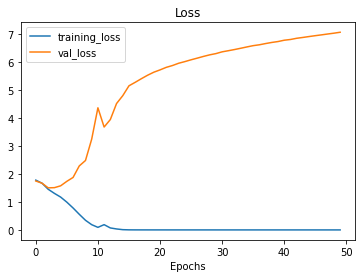

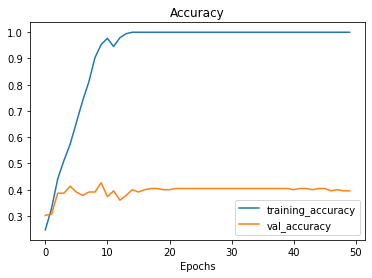

In [35]:
plot_loss_curves(history)

On constate un phénomène de sur-apprentissage: notre modèle arrive à prédire parfaitement les données d'entraînement, mais il échoue sur le jeu de test.

## Prédiction

Dans cette section on met en place le nécessaire pour mettre les prédictions de nos modèles sous une "bonne" forme et pour visualiser la qualité des prédictions via une matrice de confusion.

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true

array([0, 4, 1, 5, 1, 0, 2, 3, 1, 2, 5, 2, 1, 3, 5, 3, 2, 3, 2, 3, 0, 5,
       3, 3, 0, 5, 4, 0, 5, 0, 5, 4, 1, 1, 3, 1, 2, 0, 3, 5, 3, 1, 4, 5,
       1, 5, 0, 4, 5, 4, 0, 1, 1, 0, 1, 0, 4, 0, 0, 4, 0, 0, 3, 2, 5, 5,
       0, 5, 2, 3, 2, 3, 0, 5, 2, 5, 4, 3, 2, 4, 0, 1, 0, 1, 1, 5, 0, 3,
       0, 0, 0, 3, 1, 1, 5, 1, 5, 4, 4, 0, 5, 2, 5, 3, 0, 1, 4, 1, 0, 1,
       1, 0, 5, 4, 2, 4, 1, 3, 1, 2, 4, 0, 4, 0, 4, 0, 1, 2, 2, 2, 0, 2,
       3, 1, 2, 3, 5, 2, 0, 3, 1, 5, 5, 4, 0, 1, 1, 3, 1, 4, 5, 0, 2, 0,
       2, 5, 1, 4, 1, 1, 3, 1, 3, 1, 0, 2, 4, 4, 3, 0, 0, 0, 0, 3, 5, 3,
       1, 1, 4, 2, 2, 4, 0, 5, 1, 0, 5, 5, 0, 5, 5, 1, 0, 4, 4, 5, 5, 1,
       5, 4, 5, 5, 1, 1, 0, 5, 5, 3, 3, 2, 1, 2, 5, 5, 5, 5, 1, 3, 1, 2,
       4, 5, 2, 5, 5], dtype=int32)

Les vraies classes sont donc des entiers compris entre 0 et 5.

In [38]:
y_pred = model.predict(test_ds)
y_pred

array([[5.5009025e-07, 1.8981615e-10, 5.9960587e-07, 9.9999881e-01,
        3.6430273e-15, 9.6309898e-24],
       [9.5382750e-02, 4.8843338e-03, 2.6544789e-04, 6.7717025e-08,
        2.2899960e-13, 8.9946735e-01],
       [3.9914942e-09, 9.9976319e-01, 2.3627418e-04, 5.3063195e-07,
        3.5115629e-15, 6.3974381e-11],
       ...,
       [6.6197769e-11, 3.8923025e-01, 3.2606472e-08, 6.1076981e-01,
        1.8778255e-08, 5.6238853e-16],
       [9.9999821e-01, 9.5174599e-08, 7.9138232e-08, 1.0996700e-09,
        1.5049685e-07, 1.4437359e-06],
       [1.9917693e-20, 1.2501220e-20, 8.7115584e-21, 1.6711512e-28,
        5.1403184e-16, 1.0000000e+00]], dtype=float32)

Nos modèles ne renvoient pas des entiers mais les probabilités pour une image d'apartenir à chaque classe.

La probabilité la plus élevée sera la classe prédite. La fonction suivante permet de d'obtenir les classes prédites.

In [39]:
def get_pred_label(y_pred):
    y_pred_label = []
    for i in range(y_pred.shape[0]):
        y_pred_label.append(np.argmax(y_pred[i]))
    return y_pred_label


In [40]:
confusion_matrix(y_true=y_true, y_pred=get_pred_label(y_pred))

array([[23,  3,  2,  9,  5,  3],
       [ 7, 15, 10,  4,  3,  6],
       [ 1,  6,  6,  4,  5,  7],
       [ 7,  4,  5, 10,  1,  3],
       [ 4,  5,  4,  3, 10,  3],
       [10,  5,  4,  0,  3, 25]])

Nous allons mettre un habillage graphique aux matrices de confusion.

In [41]:
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    """
    Créer une matrice de confusion avec des couleurs pour distinguer ce qui est bon ou mauvais
    bon = diagonale foncée + le reste clair
    
    Arguments:
        y_true: Array des vrais labels
        y_pred: Array des labels prédits (même format que y_true)
        classes: Array des labels (noms de type string), si 'None' on utilisera des entiers
        figsize: Taille de la figure en sortie ( par defaut (10, 10))
        text_size: Taille des textes en sortie (par defaut 15)
    
    """
    
    # Création de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalisée
    n_classes = cm.shape[0] # nombre de classes présentes
    
    # Tracer de la figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    # classes
    if classes:
        labels = classes
    else:
        labels = np.arange(n_classes)
        
    # Les axes
    
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes), 
           yticks=np.arange(n_classes), 
           xticklabels=labels, 
           yticklabels=labels)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # Seuil pour les différentes couleurs
    
    seuil = (cm.max() + cm.min()) / 2
    
    # Ajout du texte dans chaque cellule
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > seuil else "black",
                 size=text_size)

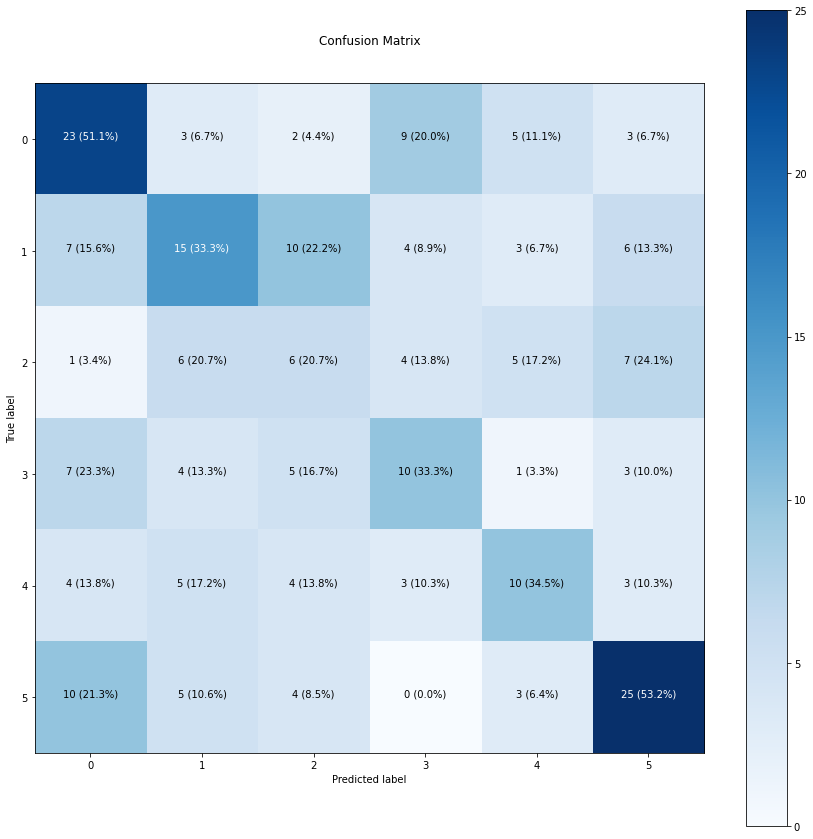

In [42]:
make_confusion_matrix(y_true=y_true, 
                      y_pred=get_pred_label(y_pred),
                      figsize=(15, 15),
                      text_size=10)

Maintenant que nous avons nos fonctions pour visualiser les résultats, nous allons faire varier certains hyperparamètres. Nous ne changerons pas les fonctions d'activation: ce sera des fonctions 'relu' sauf pour la dernière couche où on utilisera 'softmax'. Nous conserverons également la structure des couches de convolution.

Remarque: tous les tests effectués lors de la phase de recherche ne figure pas dans ce notebook, j'ai conservé les plus pertinents.

## Ajout de couches

In [45]:
def build_model(layers, optimizers):
    """
    layers : liste contenant le nombre de neurones sur chaque couche dense
    optimizers : l'optimizer utilisé pour la compilation du modèle
    """
    
    model = Sequential([
      Rescaling(1./255,  input_shape=(imgsize, imgsize, 3)),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      MaxPool2D(),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      MaxPool2D(),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      MaxPool2D(),
      Flatten()])
    
    for i in layers[:-1]:
        model.add(Dense(i, activation='relu'))
    model.add(Dense(layers[-1], activation='softmax'))
        
    model.compile(loss="SparseCategoricalCrossentropy", 
                    optimizer=optimizers,
                    metrics=["accuracy"])
    return model

In [46]:
model = build_model([20, nbr_classes], tf.keras.optimizers.Adam())

history = model.fit(train_ds,  
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=test_ds)

Epoch 1/50
29/29 [==============================] - 2s 49ms/step - loss: 1.7765 - accuracy: 0.2067 - val_loss: 1.7687 - val_accuracy: 0.2089
Epoch 2/50
29/29 [==============================] - 1s 42ms/step - loss: 1.7345 - accuracy: 0.2411 - val_loss: 1.7474 - val_accuracy: 0.2311
Epoch 3/50
29/29 [==============================] - 1s 43ms/step - loss: 1.6324 - accuracy: 0.3456 - val_loss: 1.6971 - val_accuracy: 0.2844
Epoch 4/50
29/29 [==============================] - 1s 42ms/step - loss: 1.5326 - accuracy: 0.3856 - val_loss: 1.6397 - val_accuracy: 0.3333
Epoch 5/50
29/29 [==============================] - 1s 42ms/step - loss: 1.4499 - accuracy: 0.4344 - val_loss: 1.6410 - val_accuracy: 0.3244
Epoch 6/50
29/29 [==============================] - 1s 42ms/step - loss: 1.3644 - accuracy: 0.4789 - val_loss: 1.6686 - val_accuracy: 0.3067
Epoch 7/50
29/29 [==============================] - 1s 42ms/step - loss: 1.2185 - accuracy: 0.5322 - val_loss: 1.6452 - val_accuracy: 0.3689
Epoch 8/50
29

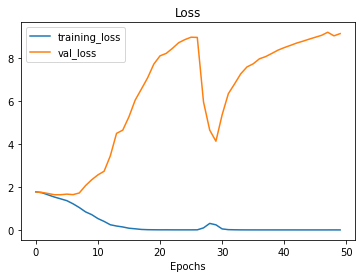

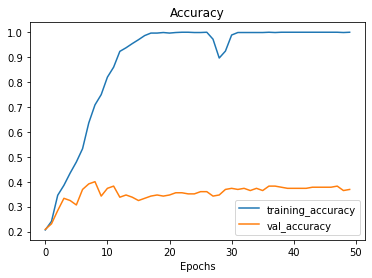

In [47]:
plot_loss_curves(history)

L'ajout d'une couche de 20 neurones n'a pas amélioré le modèle. Nous rajouterons une couche à la section suivante. 

## Tests de différents optimizers

Dans cette section nous allons comparer 4 optimizers pour un même modèle.

In [48]:
model = build_model([20, 20, nbr_classes], tf.keras.optimizers.Adam())


history_adam = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds,
                        verbose=0)

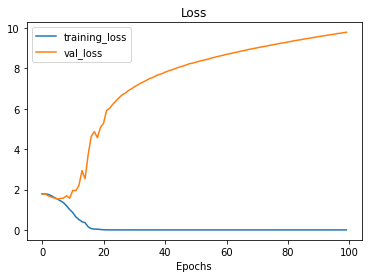

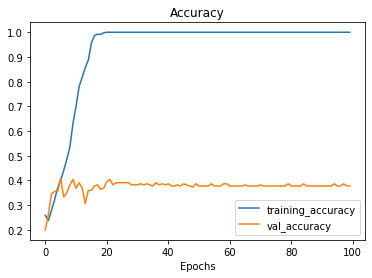

In [49]:
plot_loss_curves(history_adam)

In [50]:
model = build_model([20, 20, nbr_classes], tf.keras.optimizers.SGD())

history_SGD = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds,
                        verbose=0)

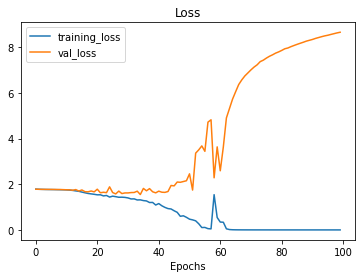

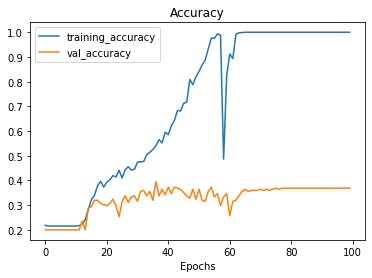

In [51]:
plot_loss_curves(history_SGD)

In [52]:
model = build_model([20, 20, nbr_classes], tf.keras.optimizers.Adagrad())

history_adagrad = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds,
                        verbose=0)

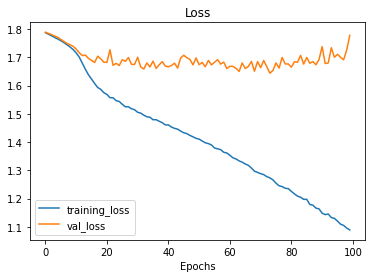

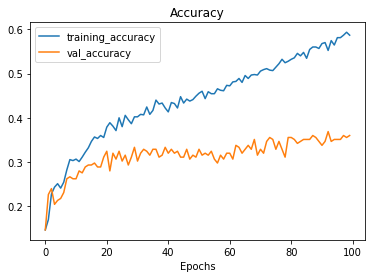

In [53]:
plot_loss_curves(history_adagrad)

In [54]:
model = build_model([20, 20, nbr_classes], tf.keras.optimizers.RMSprop())

history_rmsprop = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds,
                        verbose=0)

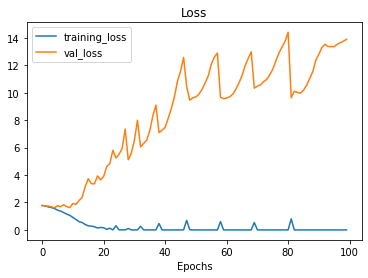

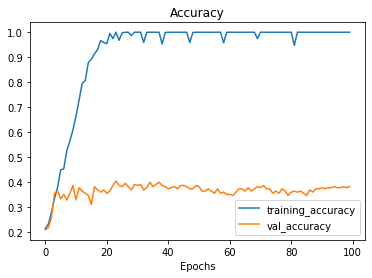

In [55]:
plot_loss_curves(history_rmsprop)

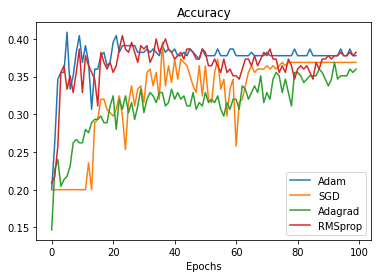

In [56]:
epochs = range(len(history_adam.history['loss']))
plt.plot(epochs, history_adam.history['val_accuracy'], label='Adam')
plt.plot(epochs, history_SGD.history['val_accuracy'], label='SGD')
plt.plot(epochs, history_adagrad.history['val_accuracy'], label='Adagrad')
plt.plot(epochs, history_rmsprop.history['val_accuracy'], label='RMSprop')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

Nous allons conserver 'Adam'.

## Recherche d'un meilleur learning rate

In [57]:
model = build_model([20, nbr_classes], tf.keras.optimizers.Adam())

# learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_ds,  
                        epochs=60,
                        batch_size=batch_size,
                        validation_data=test_ds,
                        callbacks=[lr_scheduler])

Epoch 1/60
29/29 [==============================] - 2s 48ms/step - loss: 1.7774 - accuracy: 0.2189 - val_loss: 1.7695 - val_accuracy: 0.2178 - lr: 1.0000e-04
Epoch 2/60
29/29 [==============================] - 1s 42ms/step - loss: 1.7575 - accuracy: 0.2533 - val_loss: 1.7643 - val_accuracy: 0.2756 - lr: 1.1220e-04
Epoch 3/60
29/29 [==============================] - 1s 42ms/step - loss: 1.7389 - accuracy: 0.2656 - val_loss: 1.7493 - val_accuracy: 0.2533 - lr: 1.2589e-04
Epoch 4/60
29/29 [==============================] - 1s 42ms/step - loss: 1.7039 - accuracy: 0.3178 - val_loss: 1.7002 - val_accuracy: 0.2978 - lr: 1.4125e-04
Epoch 5/60
29/29 [==============================] - 1s 42ms/step - loss: 1.6186 - accuracy: 0.3622 - val_loss: 1.6547 - val_accuracy: 0.3067 - lr: 1.5849e-04
Epoch 6/60
29/29 [==============================] - 1s 44ms/step - loss: 1.4972 - accuracy: 0.4222 - val_loss: 1.5640 - val_accuracy: 0.4000 - lr: 1.7783e-04
Epoch 7/60
29/29 [==============================] - 

Text(0.5, 1.0, 'Recherche du meilleur learning rate')

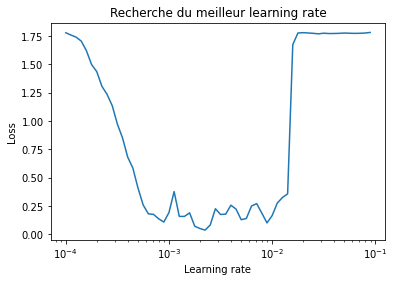

In [59]:
lrs = 1e-4 * (10**(np.arange(60)/20))
plt.semilogx(lrs, history.history["loss"]) 
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Recherche du meilleur learning rate")

Le meilleur learning rate devrait donc être environ 0.0008.

## Avec Data augmentation

Nous avons constaté un problème de sur-apprentissage de nos modèles.

Dans cette section nous allons voir si le fait de modifier légèrement et de manière aléatoire les données d'entraînement au cours de l'entraînement permet d'éviter le sur-apprentissage.

Nous n'allons pas utiliser l'ImageDataGenerator car la documentation indique que cette classe est obsolete. Nous allons inclure directement dans la structure des modèles des couches pour la data augmentation.

In [60]:
from tensorflow.keras import layers

In [61]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("vertical",
                      input_shape=(imgsize, imgsize, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
  ]
)

Des tests effectués en phase de recherche ont montré qu'il ne faut pas trop mettre de data augmentation sinon le modèle se détériore.

In [62]:
def build_model_aug(layers, data_augmentation, lr=0.001):
    
    model = Sequential([
      data_augmentation,
      Rescaling(1./255,  input_shape=(imgsize, imgsize, 3)),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      MaxPool2D(),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      MaxPool2D(),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      MaxPool2D(),
      Flatten()])
    
    for i in layers[:-1]:
        model.add(Dense(i, activation='relu'))
    model.add(Dense(layers[-1], activation='softmax'))
        
    model.compile(loss="SparseCategoricalCrossentropy", 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=["accuracy"])
    return model

In [112]:
model = build_model_aug([20, 20, nbr_classes], data_augmentation)

history = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds)

Epoch 1/100
29/29 [==============================] - 3s 53ms/step - loss: 1.7883 - accuracy: 0.2222 - val_loss: 1.7820 - val_accuracy: 0.2089
Epoch 2/100
29/29 [==============================] - 1s 45ms/step - loss: 1.7647 - accuracy: 0.2233 - val_loss: 1.7592 - val_accuracy: 0.2356
Epoch 3/100
29/29 [==============================] - 1s 46ms/step - loss: 1.7213 - accuracy: 0.2967 - val_loss: 1.7057 - val_accuracy: 0.2622
Epoch 4/100
29/29 [==============================] - 1s 46ms/step - loss: 1.6479 - accuracy: 0.3222 - val_loss: 1.6112 - val_accuracy: 0.3200
Epoch 5/100
29/29 [==============================] - 1s 45ms/step - loss: 1.5885 - accuracy: 0.3333 - val_loss: 1.6026 - val_accuracy: 0.3067
Epoch 6/100
29/29 [==============================] - 1s 45ms/step - loss: 1.5913 - accuracy: 0.3300 - val_loss: 1.5843 - val_accuracy: 0.3156
Epoch 7/100
29/29 [==============================] - 1s 46ms/step - loss: 1.6064 - accuracy: 0.3556 - val_loss: 1.6149 - val_accuracy: 0.3289
Epoch 

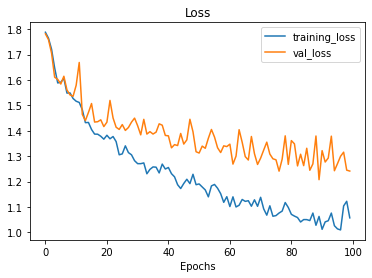

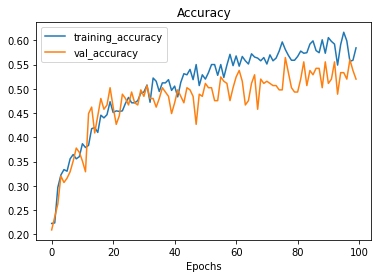

In [113]:
plot_loss_curves(history)

On constate qu'il n'y a plus de problème de sur-apprentissage (tout du moins sur 100 epochs) ainsi qu'une amélioration significative du modèle.

In [114]:
y_pred = model.predict(test_ds)

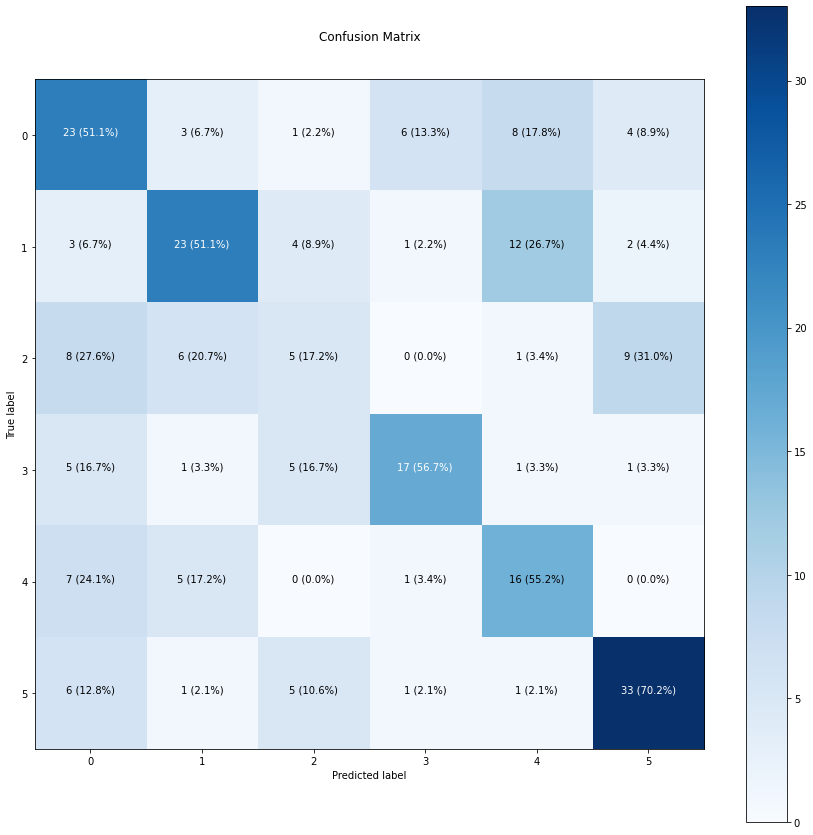

In [115]:
make_confusion_matrix(y_true=y_true, 
                      y_pred=get_pred_label(y_pred),
                      figsize=(15, 15),
                      text_size=10)

## Optimisation des hyperparamètres

Ce que nous avons fait jusqu'à maintenant pour trouver de mailleurs hyperparamètres est très laborieux.

La bibliothèque keras-tuner permet d'automatiser l'optimisation des hyperparamètres.

In [67]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 9.3 MB/s 
     |████████████████████████████████| 1.6 MB 58.6 MB/s 


In [68]:
import keras_tuner

C'est surtout le nombre de couche et de neurones par couche que nous n'avons pas optimisé. Nous allons tester entre 1 et 3 couches de 20 à 100 neurones par pas de 20 (plus la dernière couche qui comporte forcément nbr_classes neurones).

In [87]:
def build_model_for_optimisation(hp):
    model = Sequential([
        Rescaling(1./255,  input_shape=(imgsize, imgsize, 3)),
        Conv2D(10, 3, activation='relu'),
        Conv2D(10, 3, activation='relu'),
        MaxPool2D(),
        Conv2D(10, 3, activation='relu'),
        Conv2D(10, 3, activation='relu'),
        MaxPool2D(),
        Conv2D(10, 3, activation='relu'),
        Conv2D(10, 3, activation='relu'),
        MaxPool2D(),
        Flatten()])
    for i in range(hp.Int('num_layers', 1, 3)):
      hp_units = hp.Int('units_'+str(i), min_value=20, max_value=100, step=10)
      model.add(Dense(units=hp_units, activation='relu'))

    model.add(Dense(nbr_classes, activation='softmax'))

    model.compile(loss="SparseCategoricalCrossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                metrics=["accuracy"])
    return model
      

In [88]:
build_model_for_optimisation(keras_tuner.HyperParameters())

In [89]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_for_optimisation,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory="opt_dir",
    project_name="opt_for_image_class",
)

In [90]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 10, 'sampling': None}


In [91]:
tuner.search(train_ds, epochs=30, validation_data=test_ds)

Trial 30 Complete [00h 01m 23s]
val_accuracy: 0.4444444477558136

Best val_accuracy So Far: 0.4888889044523239
Total elapsed time: 00h 43m 32s


In [92]:
models = tuner.get_best_models(num_models=1)

In [ ]:
best_model = models[0]

In [94]:
best_model.build()

In [95]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                        

Nous allons donc utiliser une seule couche dense intermédiaire, de 100 neurones.

In [96]:
model = build_model_aug([100, nbr_classes], data_augmentation, lr=0.0008)

history = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds)

Epoch 1/100
29/29 [==============================] - 3s 52ms/step - loss: 1.7601 - accuracy: 0.2267 - val_loss: 1.7321 - val_accuracy: 0.2667
Epoch 2/100
29/29 [==============================] - 1s 44ms/step - loss: 1.6857 - accuracy: 0.2900 - val_loss: 1.6765 - val_accuracy: 0.2844
Epoch 3/100
29/29 [==============================] - 1s 45ms/step - loss: 1.6281 - accuracy: 0.3222 - val_loss: 1.6115 - val_accuracy: 0.3644
Epoch 4/100
29/29 [==============================] - 1s 45ms/step - loss: 1.6054 - accuracy: 0.3333 - val_loss: 1.6217 - val_accuracy: 0.3244
Epoch 5/100
29/29 [==============================] - 1s 45ms/step - loss: 1.5637 - accuracy: 0.3700 - val_loss: 1.5990 - val_accuracy: 0.3067
Epoch 6/100
29/29 [==============================] - 1s 45ms/step - loss: 1.5631 - accuracy: 0.3522 - val_loss: 1.5397 - val_accuracy: 0.3822
Epoch 7/100
29/29 [==============================] - 1s 45ms/step - loss: 1.5244 - accuracy: 0.3756 - val_loss: 1.4905 - val_accuracy: 0.3911
Epoch 

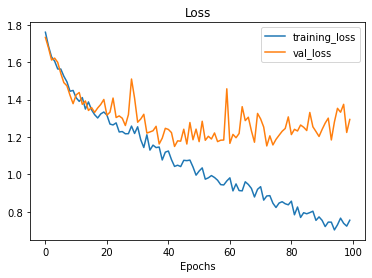

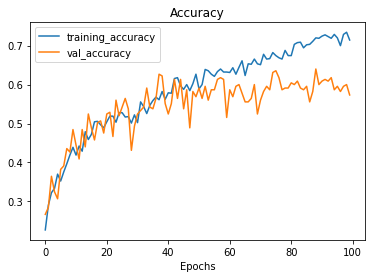

In [97]:
plot_loss_curves(history)

On obtient effectivement un meilleur résultat.

In [98]:
y_pred = model.predict(test_ds)

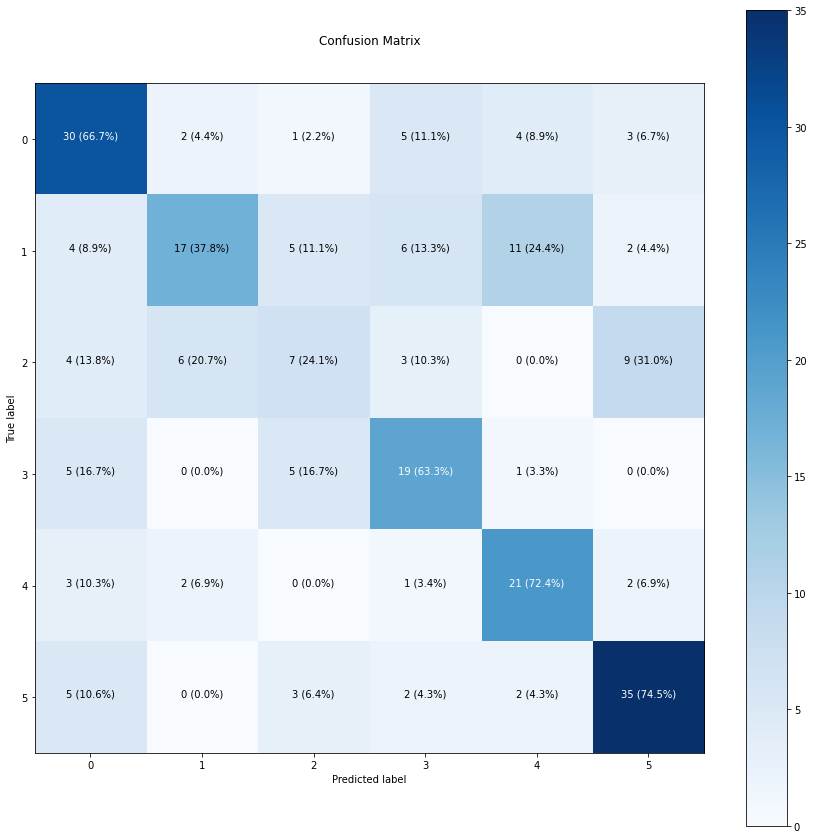

In [99]:
make_confusion_matrix(y_true=y_true, 
                      y_pred=get_pred_label(y_pred),
                      figsize=(15, 15),
                      text_size=10)

Ceci était le dernier modèle de cette première approche (et le meilleur modèle). Passons maintenant au transfert learning.

# Transfert learning

L'idée est d'utiliser un modèle déjà entraîné à reconnaitre une image de chien et de seulement changer et entraîner la dernière couche du modèle.

Nous allons tester deux modèles: VGG16 et InceptionResnetV2.

## VGG16

In [100]:
from keras.applications.vgg16 import VGG16

In [101]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [102]:
# On ne veut pas modifier les poids de base_model
for layer in base_model.layers:
    layer.trainable = False

In [103]:
model = Sequential()
model.add(Rescaling(1./255,  input_shape=(imgsize, imgsize, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(nbr_classes,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
______________________________________

In [105]:
model.compile(
    loss='SparseCategoricalCrossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    metrics=['accuracy']
)

In [106]:
history = model.fit(train_ds,  
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=test_ds)

Epoch 1/100
29/29 [==============================] - 11s 255ms/step - loss: 1.9954 - accuracy: 0.1900 - val_loss: 1.7744 - val_accuracy: 0.2267
Epoch 2/100
29/29 [==============================] - 6s 199ms/step - loss: 1.8704 - accuracy: 0.2222 - val_loss: 1.6889 - val_accuracy: 0.3022
Epoch 3/100
29/29 [==============================] - 6s 200ms/step - loss: 1.7586 - accuracy: 0.2789 - val_loss: 1.6290 - val_accuracy: 0.3778
Epoch 4/100
29/29 [==============================] - 6s 201ms/step - loss: 1.6554 - accuracy: 0.3489 - val_loss: 1.5695 - val_accuracy: 0.4667
Epoch 5/100
29/29 [==============================] - 6s 201ms/step - loss: 1.6043 - accuracy: 0.3789 - val_loss: 1.5222 - val_accuracy: 0.5022
Epoch 6/100
29/29 [==============================] - 6s 200ms/step - loss: 1.5472 - accuracy: 0.4467 - val_loss: 1.4732 - val_accuracy: 0.5422
Epoch 7/100
29/29 [==============================] - 6s 200ms/step - loss: 1.5157 - accuracy: 0.4300 - val_loss: 1.4368 - val_accuracy: 0.564

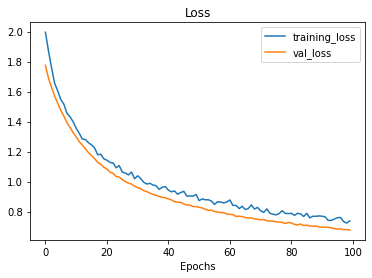

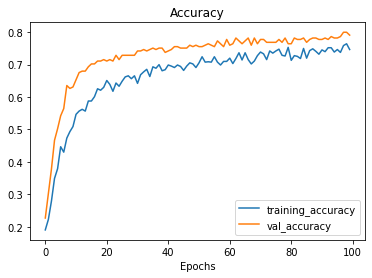

In [107]:
plot_loss_curves(history)

In [108]:
y_pred = model.predict(test_ds)

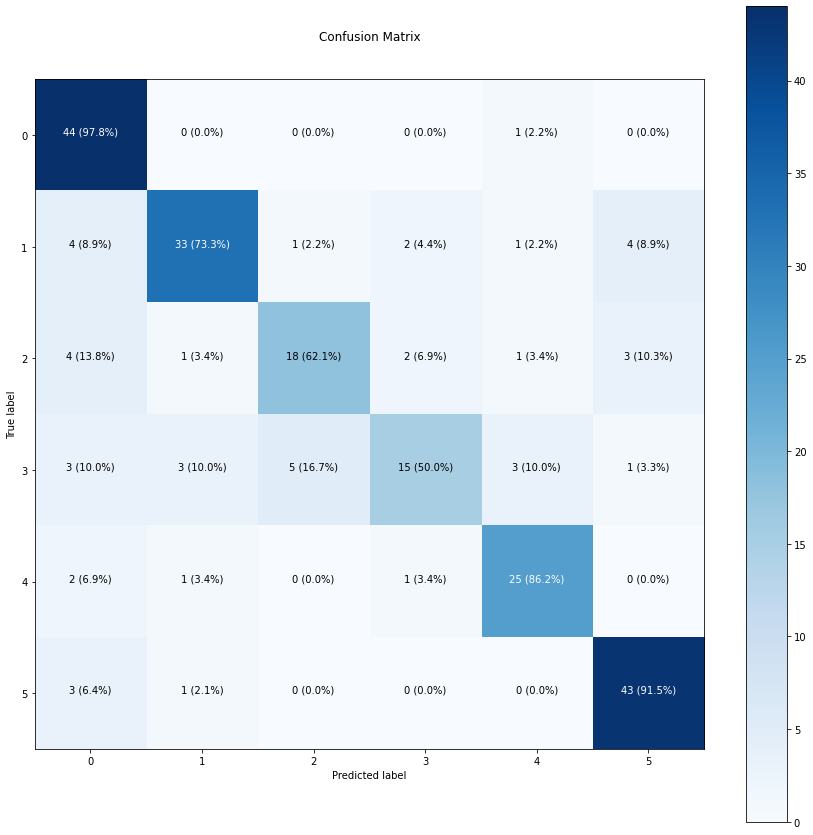

In [109]:
make_confusion_matrix(y_true=y_true, 
                      y_pred=get_pred_label(y_pred),
                      figsize=(15, 15),
                      text_size=10)

C'est effectivement beaucoup mieux que ce que nous avons entraîné entièrement nous même. Nous allons sauvegarder ce modèle pour l'utiliser dans notre application (le modèle suivant sera meilleur mais beaucoup plus lourd).

In [110]:
model.save('/content/gdrive/MyDrive/saved_models/vgg16_model')

## InceptionResnetV2

In [116]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

219070464/219055592 [==============================] - 2s 0us/step


In [117]:
for layer in base_model.layers:
    layer.trainable = False

In [118]:
model = Sequential()
model.add(Rescaling(1./255,  input_shape=(imgsize, imgsize, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(6,activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_11 (Dense)            (None, 6)                 9222      
                                                                 
Total params: 54,345,958
Trainable params: 9,222
Non-t

In [119]:
model.compile(
    loss='SparseCategoricalCrossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [120]:
history = model.fit(train_ds,  
                        epochs=20,
                        batch_size=batch_size,
                        validation_data=test_ds)

Epoch 1/20
29/29 [==============================] - 21s 381ms/step - loss: 0.4340 - accuracy: 0.8600 - val_loss: 0.0385 - val_accuracy: 0.9911
Epoch 2/20
29/29 [==============================] - 7s 225ms/step - loss: 0.0431 - accuracy: 0.9878 - val_loss: 0.0416 - val_accuracy: 0.9867
Epoch 3/20
29/29 [==============================] - 7s 228ms/step - loss: 0.0470 - accuracy: 0.9844 - val_loss: 0.0279 - val_accuracy: 0.9911
Epoch 4/20
29/29 [==============================] - 7s 234ms/step - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.0306 - val_accuracy: 0.9911
Epoch 5/20
29/29 [==============================] - 7s 231ms/step - loss: 0.0372 - accuracy: 0.9867 - val_loss: 0.0380 - val_accuracy: 0.9867
Epoch 6/20
29/29 [==============================] - 7s 229ms/step - loss: 0.0208 - accuracy: 0.9922 - val_loss: 0.0278 - val_accuracy: 0.9911
Epoch 7/20
29/29 [==============================] - 7s 227ms/step - loss: 0.0240 - accuracy: 0.9911 - val_loss: 0.0256 - val_accuracy: 0.9911
Epoch

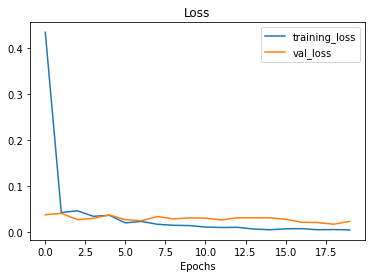

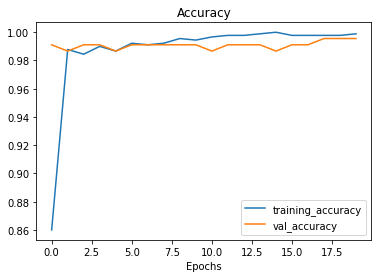

In [121]:
plot_loss_curves(history)

In [122]:
y_pred = model.predict(test_ds)

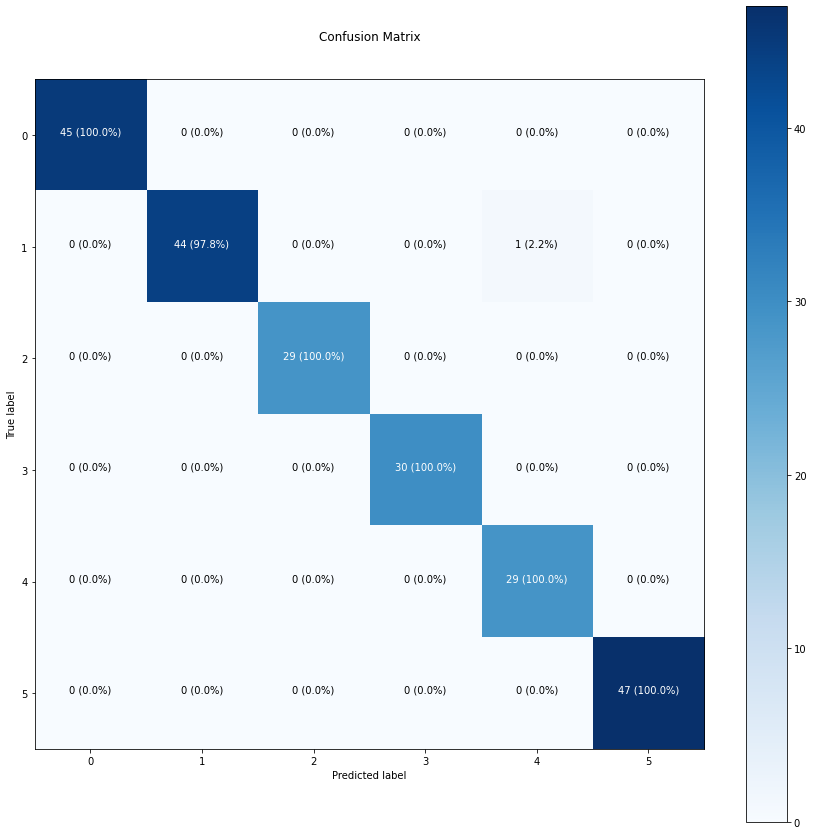

In [123]:
make_confusion_matrix(y_true=y_true, 
                      y_pred=get_pred_label(y_pred),
                      figsize=(15, 15),
                      text_size=10)

Ce modèle est excellent.